In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention_gl as SelfAttention,CrossAttention_gl as CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'headline', 'id', 'type', 'urls'], dtype='object'),
 705,
 705)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

125

In [5]:
hdl = "George Soros: Trump Will Win Popular Vote by a Landslide but Clinton Victory a 'Done Deal'"
hdl = "Ted Cruz Said 'If Something Happens to Hillary' He'll 'Run as a Democrat Against Trump'"
# hdl = "If You Thought The Trump Child Rape Case In NY Couldn’t Get Much Worse — You Were Wrong"
# hdl = "California Set to Let Public Schools Teach Primarily in Spanish"
dnf700[dnf700.headline==hdl]

,authors,headline,id,type,urls


In [6]:
titles = sorted(dnf700.headline.unique())
len(titles)

698

In [7]:
test_titles = sorted(dnf_eval.headline.unique())
len(test_titles)
test_titles

['(VIDEO) Female College Students Protesting Because ‘Trump is a Rapist’',
 'Assange Confirms: WikiLeaks Didn’t Get Emails From Russian Govt',
 'BREAKING: Fraudulent Clinton Votes Discovered By The “Tens Of Thousands”',
 "Clinton Camp Demands 'Compliant Citizenry' for Master Plan",
 'Clinton Received Debate Questions Week Before Debate',
 "DOJ's Loretta Lynch Tried To Squash Comey's Letter To Congress",
 'Department of Homeland Security Chairman Officially Indicts Hillary Clinton of Treason',
 'Developing: Obama WH admits that Hillary gave ISIS $400 million on accident',
 'Erdoğan: US, the founder of ISIS',
 "FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 'FBI Agent Suspected in Hillary Email Leaks Found Dead in Apparent Murder-Suicide',
 'FBI Director Comey’s ‘Leaked’ Memo Explains Why He’s Reopening the Clinton Email Case',
 'FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes',
 '

In [8]:
non_test_titles = np.array(list(set(titles)-set(test_titles)))
len(non_test_titles)

650

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370 371 372 373 374 375 37

(520, 130, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            sentences = articles300[ar_id]
            vectors = article_vectors300[ar_id]
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
                sentences=articles[ar_id]
                vectors = article_vectors[ar_id]
            except Exception as ex:
                print(ex)
                print(idx)
            
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf700,mode='train')
vdg = datagen_dnf(val_batchsize,dnf700,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf700,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 125, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 125, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

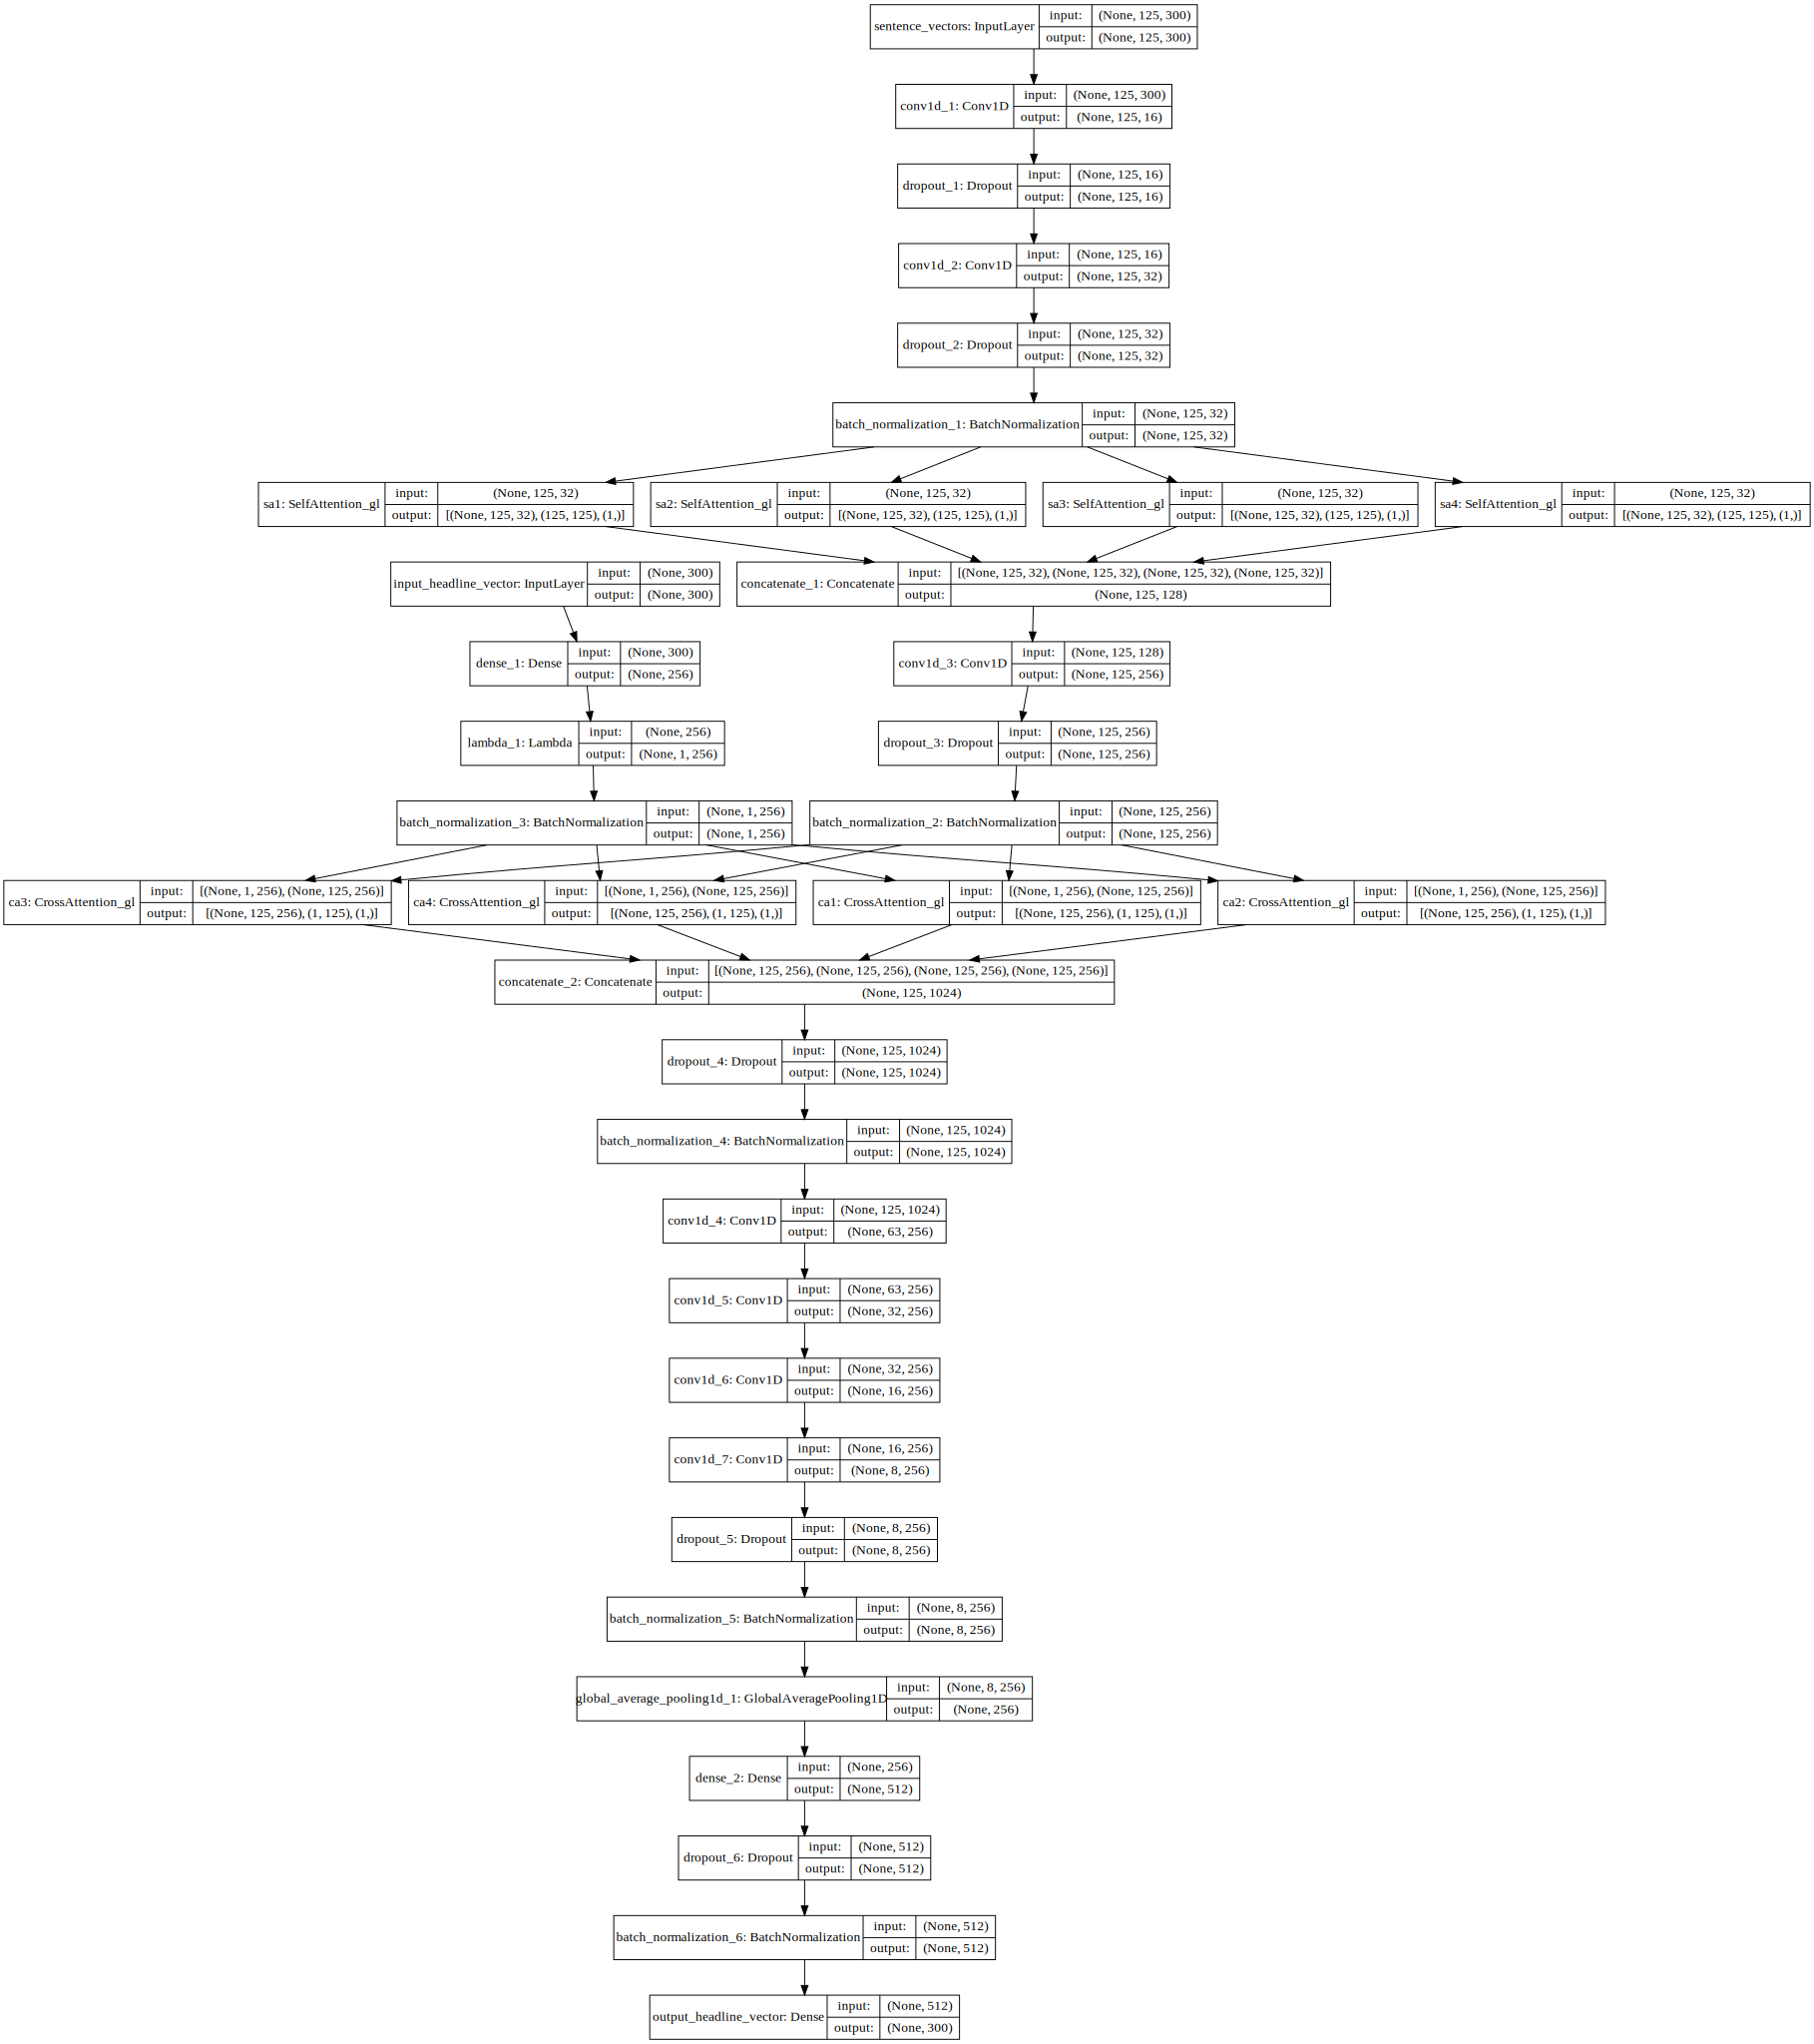

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf700_sa_sent_hd_vector_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf700_sa_sent_hd_vector_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [18]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 13s 3s/step - loss: 0.0340 - val_loss: 0.0356
Epoch 2/2000
4/4 [==============================] - 0s 65ms/step - loss: 0.0337 - val_loss: 0.0307
Epoch 3/2000
4/4 [==============================] - 0s 62ms/step - loss: 0.0339 - val_loss: 0.0303
Epoch 4/2000
4/4 [==============================] - 1s 345ms/step - loss: 0.0342 - val_loss: 0.0305
Epoch 5/2000
4/4 [==============================] - 3s 743ms/step - loss: 0.0337 - val_loss: 0.0348
Epoch 6/2000
4/4 [==============================] - 3s 673ms/step - loss: 0.0321 - val_loss: 0.0316
Epoch 7/2000
4/4 [==============================] - 3s 690ms/step - loss: 0.0332 - val_loss: 0.0315
Epoch 8/2000
4/4 [==============================] - 3s 790ms/step - loss: 0.0315 - val_loss: 0.0323
Epoch 9/2000
4/4 [==============================] - 3s 667ms/step - loss: 0.0313 - val_loss: 0.0311
Epoch 10/2000
4/4 [==============================] - 3s 664ms/step - loss: 0.0315 - val_loss: 0.0303
Epo

4/4 [==============================] - 3s 829ms/step - loss: 0.0126 - val_loss: 0.0131
Epoch 83/2000
4/4 [==============================] - 3s 792ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 84/2000
4/4 [==============================] - 3s 827ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 85/2000
4/4 [==============================] - 3s 713ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 86/2000
4/4 [==============================] - 3s 772ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 87/2000
4/4 [==============================] - 3s 790ms/step - loss: 0.0124 - val_loss: 0.0130
Epoch 88/2000
4/4 [==============================] - 4s 910ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 89/2000
4/4 [==============================] - 3s 696ms/step - loss: 0.0124 - val_loss: 0.0145
Epoch 90/2000
4/4 [==============================] - 3s 636ms/step - loss: 0.0118 - val_loss: 0.0135
Epoch 91/2000
4/4 [==============================] - 2s 607ms/step - loss: 0.0112 - val_loss: 0.0116
Epoc

4/4 [==============================] - 3s 632ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 163/2000
4/4 [==============================] - 3s 711ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 164/2000
4/4 [==============================] - 3s 705ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 165/2000
4/4 [==============================] - 3s 729ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 166/2000
4/4 [==============================] - 3s 715ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 167/2000
4/4 [==============================] - 3s 661ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 168/2000
4/4 [==============================] - 3s 629ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 169/2000
4/4 [==============================] - 3s 797ms/step - loss: 0.0116 - val_loss: 0.0103
Epoch 170/2000
4/4 [==============================] - 3s 686ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 171/2000
4/4 [==============================] - 3s 716ms/step - loss: 0.0117 - val_loss: 0.

4/4 [==============================] - 4s 1s/step - loss: 0.0118 - val_loss: 0.0110
Epoch 243/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0111 - val_loss: 0.0110
Epoch 244/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0111 - val_loss: 0.0111
Epoch 245/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0122 - val_loss: 0.0114
Epoch 246/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0113 - val_loss: 0.0116
Epoch 247/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0091
Epoch 248/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0107 - val_loss: 0.0097
Epoch 249/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0122 - val_loss: 0.0106
Epoch 250/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0116 - val_loss: 0.0101
Epoch 251/2000
4/4 [==============================] - 4s 960ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 252/2000
4/4 [==

Epoch 325/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0110
Epoch 326/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0106
Epoch 327/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0112 - val_loss: 0.0114
Epoch 328/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0104 - val_loss: 0.0101
Epoch 329/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0116
Epoch 330/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0100
Epoch 331/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0112
Epoch 332/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0116 - val_loss: 0.0101
Epoch 333/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0104 - val_loss: 0.0106
Epoch 334/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0129
Epoch 335/

4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0113
Epoch 408/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0104
Epoch 409/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0109
Epoch 410/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0109
Epoch 411/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0107 - val_loss: 0.0110
Epoch 412/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0119 - val_loss: 0.0120
Epoch 413/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0092
Epoch 414/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0102 - val_loss: 0.0105
Epoch 415/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0104 - val_loss: 0.0120
Epoch 416/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0114 - val_loss: 0.0107
Epoch 417/2000
4/4 [=====

Epoch 490/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0125 - val_loss: 0.0121
Epoch 491/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0111
Epoch 492/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0119 - val_loss: 0.0124
Epoch 493/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0102 - val_loss: 0.0103
Epoch 494/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0109 - val_loss: 0.0112
Epoch 495/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0112 - val_loss: 0.0116
Epoch 496/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0103
Epoch 497/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0116 - val_loss: 0.0117
Epoch 498/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0115
Epoch 499/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0115 - val_loss: 0.0111
Epoch 500/

4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0111
Epoch 573/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0102 - val_loss: 0.0120
Epoch 574/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0117 - val_loss: 0.0119
Epoch 575/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0129
Epoch 576/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0105
Epoch 577/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0109 - val_loss: 0.0104
Epoch 578/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0119 - val_loss: 0.0112
Epoch 579/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0116 - val_loss: 0.0120
Epoch 580/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0119
Epoch 581/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0108 - val_loss: 0.0109
Epoch 582/2000
4/4 [=====

Epoch 655/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0123 - val_loss: 0.0104
Epoch 656/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0110 - val_loss: 0.0105
Epoch 657/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0116 - val_loss: 0.0108
Epoch 658/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0122 - val_loss: 0.0103
Epoch 659/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0104 - val_loss: 0.0101
Epoch 660/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0099 - val_loss: 0.0111
Epoch 661/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0108
Epoch 662/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0109
Epoch 663/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0114 - val_loss: 0.0112
Epoch 664/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0116 - val_loss: 0.0104
Epoch 665/

4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0100
Epoch 738/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0100 - val_loss: 0.0116
Epoch 739/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0113
Epoch 740/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0090
Epoch 741/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0121 - val_loss: 0.0105
Epoch 742/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0103
Epoch 743/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0101
Epoch 744/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0105
Epoch 745/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0113 - val_loss: 0.0110
Epoch 746/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0115 - val_loss: 0.0100
Epoch 747/2000
4/4 [=====

Epoch 820/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0108
Epoch 821/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0104
Epoch 822/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0109
Epoch 823/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0100
Epoch 824/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0096 - val_loss: 0.0124
Epoch 825/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0114
Epoch 826/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0107
Epoch 827/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0098
Epoch 828/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0118 - val_loss: 0.0108
Epoch 829/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0119 - val_loss: 0.0120
Epoch 830/

4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0108
Epoch 903/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0111 - val_loss: 0.0106
Epoch 904/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0118 - val_loss: 0.0110
Epoch 905/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0096
Epoch 906/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0114
Epoch 907/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0112
Epoch 908/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0105 - val_loss: 0.0117
Epoch 909/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0100 - val_loss: 0.0111
Epoch 910/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0126 - val_loss: 0.0103
Epoch 911/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0112
Epoch 912/2000
4/4 [=====

Epoch 985/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0104
Epoch 986/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0103
Epoch 987/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0099 - val_loss: 0.0120
Epoch 988/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0124 - val_loss: 0.0122
Epoch 989/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0111 - val_loss: 0.0103
Epoch 990/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0119
Epoch 991/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0094 - val_loss: 0.0110
Epoch 992/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0121
Epoch 993/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0117 - val_loss: 0.0104
Epoch 994/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0102
Epoch 995/

4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0105
Epoch 1068/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0101 - val_loss: 0.0116
Epoch 1069/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0115 - val_loss: 0.0106
Epoch 1070/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0101
Epoch 1071/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0101
Epoch 1072/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0110
Epoch 1073/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0108
Epoch 1074/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0116
Epoch 1075/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0100 - val_loss: 0.0112
Epoch 1076/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0100
Epoch 1077/2000


4/4 [==============================] - 5s 1s/step - loss: 0.0111 - val_loss: 0.0105
Epoch 1150/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0112 - val_loss: 0.0108
Epoch 1151/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0117 - val_loss: 0.0110
Epoch 1152/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0109
Epoch 1153/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0125 - val_loss: 0.0118
Epoch 1154/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0114 - val_loss: 0.0120
Epoch 1155/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0122 - val_loss: 0.0111
Epoch 1156/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0120 - val_loss: 0.0106
Epoch 1157/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0124 - val_loss: 0.0115
Epoch 1158/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0116 - val_loss: 0.0111
Epoch 1159/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0101
Epoch 1232/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0108
Epoch 1233/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0127 - val_loss: 0.0113
Epoch 1234/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0102 - val_loss: 0.0119
Epoch 1235/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0111
Epoch 1236/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0125
Epoch 1237/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0124
Epoch 1238/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0106
Epoch 1239/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0117
Epoch 1240/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0113 - val_loss: 0.0110
Epoch 1241/2000


4/4 [==============================] - 7s 2s/step - loss: 0.0121 - val_loss: 0.0120
Epoch 1314/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0102
Epoch 1315/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0105
Epoch 1316/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0123 - val_loss: 0.0099
Epoch 1317/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0119
Epoch 1318/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0118 - val_loss: 0.0107
Epoch 1319/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0105
Epoch 1320/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0118 - val_loss: 0.0114
Epoch 1321/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0120 - val_loss: 0.0104
Epoch 1322/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0105 - val_loss: 0.0108
Epoch 1323/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0118 - val_loss: 0.0101
Epoch 1396/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0106 - val_loss: 0.0108
Epoch 1397/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0114 - val_loss: 0.0102
Epoch 1398/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0121 - val_loss: 0.0113
Epoch 1399/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0114
Epoch 1400/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0119 - val_loss: 0.0114
Epoch 1401/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0109
Epoch 1402/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0095
Epoch 1403/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0120 - val_loss: 0.0092
Epoch 1404/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0111 - val_loss: 0.0098
Epoch 1405/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0107
Epoch 1478/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0107
Epoch 1479/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0111
Epoch 1480/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 1481/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0116 - val_loss: 0.0115
Epoch 1482/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0127
Epoch 1483/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0117 - val_loss: 0.0104
Epoch 1484/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0114 - val_loss: 0.0128
Epoch 1485/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0111 - val_loss: 0.0108
Epoch 1486/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0107
Epoch 1487/2000


4/4 [==============================] - 7s 2s/step - loss: 0.0100 - val_loss: 0.0134
Epoch 1560/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0116
Epoch 1561/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0104 - val_loss: 0.0114
Epoch 1562/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0102
Epoch 1563/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0111
Epoch 1564/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0119 - val_loss: 0.0110
Epoch 1565/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0130 - val_loss: 0.0103
Epoch 1566/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0099 - val_loss: 0.0118
Epoch 1567/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0098 - val_loss: 0.0103
Epoch 1568/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0111 - val_loss: 0.0102
Epoch 1569/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0093
Epoch 1642/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0103
Epoch 1643/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0117 - val_loss: 0.0113
Epoch 1644/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0099
Epoch 1645/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0097
Epoch 1646/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0098
Epoch 1647/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0118 - val_loss: 0.0107
Epoch 1648/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0110
Epoch 1649/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0114
Epoch 1650/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0103 - val_loss: 0.0106
Epoch 1651/2000


4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0109
Epoch 1724/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0100
Epoch 1725/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0111
Epoch 1726/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0119
Epoch 1727/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0102
Epoch 1728/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0107
Epoch 1729/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0107
Epoch 1730/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0103
Epoch 1731/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0112 - val_loss: 0.0113
Epoch 1732/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0104
Epoch 1733/2000


4/4 [==============================] - 5s 1s/step - loss: 0.0119 - val_loss: 0.0093
Epoch 1806/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0114 - val_loss: 0.0101
Epoch 1807/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0109 - val_loss: 0.0107
Epoch 1808/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0092
Epoch 1809/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0120 - val_loss: 0.0108
Epoch 1810/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0119
Epoch 1811/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0132
Epoch 1812/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0114 - val_loss: 0.0114
Epoch 1813/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0119 - val_loss: 0.0106
Epoch 1814/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0116 - val_loss: 0.0113
Epoch 1815/2000


Epoch 1887/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0111 - val_loss: 0.0118
Epoch 1888/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0130 - val_loss: 0.0103
Epoch 1889/2000
4/4 [==============================] - 4s 919ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 1890/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0109
Epoch 1891/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0102 - val_loss: 0.0117
Epoch 1892/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0115 - val_loss: 0.0116
Epoch 1893/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0105 - val_loss: 0.0087
Epoch 1894/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0114 - val_loss: 0.0096
Epoch 1895/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0096 - val_loss: 0.0113
Epoch 1896/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0119 - val_loss: 0.01

4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0105
Epoch 1969/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0110 - val_loss: 0.0128
Epoch 1970/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0105 - val_loss: 0.0105
Epoch 1971/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0106 - val_loss: 0.0123
Epoch 1972/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0111 - val_loss: 0.0096
Epoch 1973/2000
4/4 [==============================] - 4s 938ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 1974/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0108 - val_loss: 0.0114
Epoch 1975/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0107
Epoch 1976/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0100 - val_loss: 0.0109
Epoch 1977/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0119 - val_loss: 0.0114
Epoch 1978/20

In [19]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [20]:
# df_res = pd.DataFrame(hist.history)

In [21]:
# df_res[['loss','val_loss']].plot()

In [22]:
# # df_res[['acc','val_acc']].plot()
# hd_nlp = nlp("What is you name my name is Anthony Gonsalves What is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony Gonsalves!".lower())
# len(hd_nlp[:50])

# Evalutate SST

In [23]:
model.load_weights('weights/dnf700_sa_sent_hd_vector_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., use_multiprocessing=True, steps=5)`
  


0.010988671518862247

In [24]:
x,y = next(test_dg)
pred = model.predict(x)

In [25]:
x['headline']

array(['trump accuses obama, hillary clinton of founding daesh',
       'pentagon seeks another $6 billion for overseas troop deployments',
       "clinton camp demands 'compliant citizenry' for master plan",
       'us officials try to scare voters with terror threat',
       'nsa whistleblower says dnc email hack was not by russia, but by us intelligence | alternative',
       'fbi director received millions from clinton foundation, his brother’s law firm does clinton’s taxes',
       'assange confirms: wikileaks didn’t get emails from russian govt',
       'fbi director comey’s ‘leaked’ memo explains why he’s reopening the clinton email case',
       "clinton camp demands 'compliant citizenry' for master plan",
       'us threatens military hacks on russia’s electric, communications grids over election',
       'fbi director received millions from clinton foundation, his brother’s law firm does clinton’s taxes',
       'hillary personally ordered ‘donald duck’ troll campaign',
     

In [26]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

'former nato chief: we need us as ‘world’s policeman’'

In [27]:
x['sentences'][test_idx]

['In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the “world’s policeman,” but with a lot more upbeat of an attitude about it than one would generally see.',
 'Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars.',
 'Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea.',
 'This of course closely mirrors recent Pentagon talk of wars in the decades to come.',
 'The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinto

# Model Test

In [28]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 125, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 125, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [29]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([5, 4, 3, 2, 1])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

6


0.0

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

'former nato chief: we need us as ‘world’s policeman’'

['In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the “world’s policeman,” but with a lot more upbeat of an attitude about it than one would generally see.',
 'Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars.',
 'The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia.',
 'Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as “very dangerous for the world.”']

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

5 : Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as “very dangerous for the world.”
4 : The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia.
3 : This of course closely mirrors recent Pentagon talk of wars in the decades to come.
2 : Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea.
1 : Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars.


In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

6


0.0

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

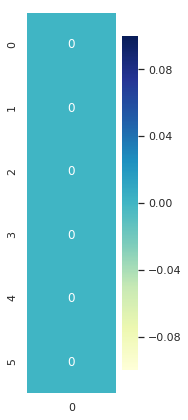

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 125, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 125, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 32)           128       
_________________________________________________________________
sa1 (SelfAttention_gl)       [(None, 125, 32), (125, 1 2378      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sb = sb1[test_idx]#+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(6, 6)

In [41]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

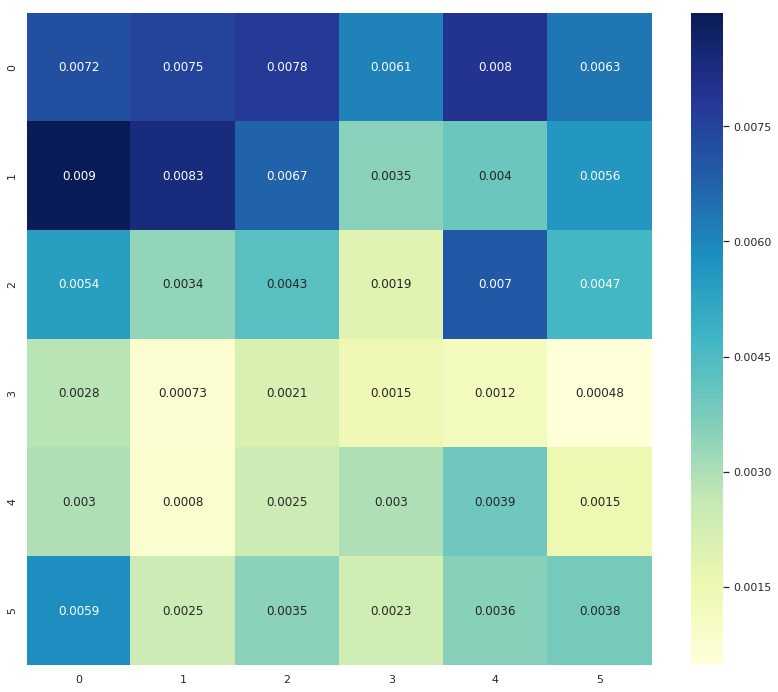

In [42]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [43]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the “world’s policeman,” but with a lot more upbeat of an attitude about it than one would generally see."
1,"Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars."
2,"Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea."
3,This of course closely mirrors recent Pentagon talk of wars in the decades to come.
4,"The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia."
5,"Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as “very dangerous for the world.”"
